In [1]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import urllib.parse
from sklearn.preprocessing import OneHotEncoder, StandardScaler # StandardScaler is for length, though you said normalized, good practice.
import numpy as np
import os
import joblib

print(torch.cuda.is_available())
print(torch.cuda.get_device_name())


C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
# --- 1. Global Model and Tokenizer Initialization (for efficiency) ---
# Load this once at the start of your script
try:
    print("Loading DistilRoBERTa model and tokenizer...")
    global_tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
    global_model = AutoModel.from_pretrained('distilroberta-base')
    global_model.eval() # Set to evaluation mode
    global_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    global_model.to(global_device)
    print(f"DistilRoBERTa model loaded on: {global_device}")
except Exception as e:
    print(f"Error loading global model or tokenizer: {e}")
    # Handle error appropriately, e.g., exit or raise
    raise

Loading DistilRoBERTa model and tokenizer...
DistilRoBERTa model loaded on: cuda


In [3]:
# --- 2. CLS Embedding Extraction Function ---
def get_cls_embedding(text: str, tokenizer, model, device, max_length: int = 512):
    """
    Helper function to get [CLS] embedding for a given text.
    Handles empty strings by returning a zero vector.
    """
    if not text:
        # Return a zero vector of the correct dimension (768 for DistilRoBERTa-base)
        return torch.zeros(model.config.hidden_size).to(device)

    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        padding='max_length',
        max_length=max_length
    )
    encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

    with torch.no_grad():
        model_output = model(**encoded_input)
        cls_embedding = model_output.last_hidden_state[0, 0, :]

    return cls_embedding

In [4]:
# Cell 5: Main Data Preprocessing Function (FIXED for CUDA Out of Memory)
def preprocess_network_logs(df: pd.DataFrame, batch_size: int = 32, max_length: int = 512):
    """
    Preprocesses the network log DataFrame for MLP training,
    using batch processing for Transformer embedding generation to mitigate OOM errors.
    This function leverages the globally loaded tokenizer, model, and device.

    Args:
        df (pd.DataFrame): The input DataFrame with 'Method', 'length', 'content', 'URL', 'Label' columns.
        batch_size (int): The number of samples to process at a time for Transformer inference.
                          Adjust this based on your GPU memory. Lower values use less memory.
        max_length (int): The maximum sequence length for tokenization.
                          Shorter values use less memory.

    Returns:
        pd.DataFrame: The preprocessed DataFrame ready for MLP training,
                      with original 'content' and 'URL' columns dropped.
    """
    # --- Section 1: Prepare Text Data for Batch Processing ---
    print("Preparing text data for batch processing...")
    # Fill NaN values with empty string for content and URL, then convert to list
    # Use .astype(str) before .fillna('') to correctly handle mixed types if any
    content_texts = df['content'].fillna('').astype(str).tolist()
    # URL-decode here once for all URLs
    url_texts = [urllib.parse.unquote(str(url)) for url in df['URL'].fillna('')]

    # Initialize lists to store embeddings (will be filled with numpy arrays)
    all_content_cls_embeddings = []
    all_url_cls_embeddings = []

    # --- Section 2: Generate CLS Embeddings in Batches ---
    print(f"Generating [CLS] embeddings in batches (batch_size={batch_size}, max_length={max_length})...")
    num_samples = len(df)
    for i in range(0, num_samples, batch_size):
        # Slice the current batch of texts
        batch_content = content_texts[i:i + batch_size]
        batch_urls = url_texts[i:i + batch_size]

        # Handle empty string inputs for tokenization:
        # If a batch element is empty, tokenizer will handle it, but it's crucial
        # that the get_cls_embedding for single strings returns zero-vectors if empty.
        # When processing a batch, an empty string will result in only CLS and SEP tokens.
        # The model will still produce a valid embedding.

        # Tokenize current batch of content
        # padding='longest' is typically used for batching to pad to the longest sequence in the batch
        # truncation=True truncates sequences longer than max_length
        encoded_content_batch = global_tokenizer(
            batch_content, return_tensors='pt', truncation=True,
            padding='longest', max_length=max_length
        )
        # Move tensors to the global device (GPU/CPU)
        encoded_content_batch = {k: v.to(global_device) for k, v in encoded_content_batch.items()}

        # Tokenize current batch of URLs
        encoded_url_batch = global_tokenizer(
            batch_urls, return_tensors='pt', truncation=True,
            padding='longest', max_length=max_length
        )
        # Move tensors to the global device (GPU/CPU)
        encoded_url_batch = {k: v.to(global_device) for k, v in encoded_url_batch.items()}

        with torch.no_grad(): # Disable gradient calculation for inference
            # Get content embeddings
            content_output = global_model(**encoded_content_batch)
            # Extract CLS token for all items in the batch: [:, 0, :]
            # Move to CPU and convert to numpy array immediately to free up GPU memory
            batch_content_cls_embeds = content_output.last_hidden_state[:, 0, :].cpu().numpy()
            all_content_cls_embeddings.extend(batch_content_cls_embeds)

            # Get URL embeddings
            url_output = global_model(**encoded_url_batch)
            batch_url_cls_embeds = url_output.last_hidden_state[:, 0, :].cpu().numpy()
            all_url_cls_embeddings.extend(batch_url_cls_embeds)

        # Clear CUDA cache aggressively after each batch (optional, but can help with fragmentation)
        torch.cuda.empty_cache()

        # Print progress
        if (i // batch_size + 1) % 100 == 0 or (i + batch_size) >= num_samples:
            print(f"Processed {min(i + batch_size, num_samples)}/{num_samples} samples...")

    print("Embedding generation complete.")

    # Create DataFrames from the accumulated lists of embeddings
    content_embed_df = pd.DataFrame(all_content_cls_embeddings, index=df.index).add_prefix('content_embed_')
    url_embed_df = pd.DataFrame(all_url_cls_embeddings, index=df.index).add_prefix('url_embed_')


    # --- Section 3: One-Hot Encode 'Method' Column ---
    print("One-hot encoding 'Method' column...")
    method_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    method_encoded = method_encoder.fit_transform(df[['Method']])
    method_encoded_df = pd.DataFrame(
        method_encoded,
        columns=method_encoder.get_feature_names_out(['Method']),
        index=df.index
    )
    print("One-hot encoding complete.")
    joblib.dump(method_encoder, 'method_encoder.pkl')
    print("OneHotEncoder for 'Method' saved to 'method_encoder.pkl'.")

    # --- Section 4: Combine All Features into Final DataFrame ---
    print("Combining all features...")
    final_df = df[['length', 'Label']].copy()

    final_df = pd.concat([final_df, method_encoded_df], axis=1)
    final_df = pd.concat([final_df, content_embed_df], axis=1)
    final_df = pd.concat([final_df, url_embed_df], axis=1)

    print("Feature combination complete.")

    return final_df

In [ ]:
# Cell 6: Load Your Dataset and Run Preprocessing
dataset_file_path = "D:\Internship ka kaam\data.csv\poroject\Horizon_log\Final_Data.csv"
df = pd.read_csv(dataset_file_path)

print("\nOriginal DataFrame head:")
print(df.head())
print("\nOriginal DataFrame info:")
df.info()
print("\nOriginal DataFrame shape:", df.shape)

# Preprocess the DataFrame
processed_df = preprocess_network_logs(df.copy(), batch_size=32, max_length=256) # Use .copy() to avoid modifying original df


Original DataFrame head:
  Method  length                                            content  \
0    GET     NaN                                                NaN   
1    GET     NaN                                                NaN   
2   POST    68.0  id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...   
3    GET     NaN                                                NaN   
4   POST    63.0  modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...   

                                                 URL  Label  
0   http://localhost:8080/tienda1/index.jsp HTTP/1.1      0  
1  http://localhost:8080/tienda1/publico/anadir.j...      0  
2  http://localhost:8080/tienda1/publico/anadir.j...      0  
3  http://localhost:8080/tienda1/publico/autentic...      0  
4  http://localhost:8080/tienda1/publico/autentic...      0  

Original DataFrame info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61065 entries, 0 to 61064
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---

<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\shiva\AppData\Local\Temp\ipykernel_25396\1946144947.py:2: SyntaxWarning: invalid escape sequence '\I'
  dataset_file_path = "D:\Internship ka kaam\data.csv\poroject\Horizon_log\Final_Data.csv"


Generating [CLS] embeddings in batches (batch_size=32, max_length=256)...
Processed 3200/61065 samples...
Processed 6400/61065 samples...
Processed 9600/61065 samples...
Processed 12800/61065 samples...
Processed 16000/61065 samples...
Processed 19200/61065 samples...
Processed 22400/61065 samples...
Processed 25600/61065 samples...
Processed 28800/61065 samples...
Processed 32000/61065 samples...
Processed 35200/61065 samples...
Processed 38400/61065 samples...
Processed 41600/61065 samples...
Processed 44800/61065 samples...
Processed 48000/61065 samples...
Processed 51200/61065 samples...
Processed 54400/61065 samples...
Processed 57600/61065 samples...
Processed 60800/61065 samples...
Processed 61065/61065 samples...
Embedding generation complete.
One-hot encoding 'Method' column...
One-hot encoding complete.
OneHotEncoder for 'Method' saved to 'method_encoder.pkl'.
Combining all features...
Feature combination complete.


In [6]:
processed_df['length']=processed_df['length'].fillna(0)
processed_df.head()

,length,Label,Method_GET,Method_POST,Method_PUT,content_embed_0,content_embed_1,content_embed_2,content_embed_3,content_embed_4,...,url_embed_758,url_embed_759,url_embed_760,url_embed_761,url_embed_762,url_embed_763,url_embed_764,url_embed_765,url_embed_766,url_embed_767
0,0.0,0,1.0,0.0,0.0,-0.028477,0.098757,0.020165,-0.138052,0.102844,...,0.019117,-0.018484,-0.057128,-0.044485,0.018033,0.089720,0.089841,-0.106350,-0.042665,0.013191
1,0.0,0,1.0,0.0,0.0,-0.028477,0.098757,0.020165,-0.138052,0.102844,...,0.019805,-0.007385,-0.098287,-0.075826,0.053666,0.058605,0.026840,-0.079029,0.002011,-0.013870
2,68.0,0,0.0,1.0,0.0,0.023022,0.042688,-0.032714,-0.080042,0.052732,...,0.016956,-0.013940,-0.061787,-0.048854,0.024243,0.080115,0.085346,-0.095609,-0.030425,0.006528
3,0.0,0,1.0,0.0,0.0,-0.028477,0.098757,0.020165,-0.138052,0.102844,...,0.045856,0.031502,-0.087172,-0.054506,0.066078,0.047454,0.035490,-0.143954,-0.016191,-0.004505
4,63.0,0,0.0,1.0,0.0,0.024269,0.072873,-0.019203,-0.063366,0.060539,...,0.016599,-0.012888,-0.052053,-0.046002,0.032960,0.086654,0.081674,-0.101176,-0.024479,-0.001528


In [7]:
import pandas as pd
import torch
import torch.nn as nn # Neural network modules
import torch.optim as optim # Optimization algorithms
from torch.utils.data import Dataset, DataLoader # For data handling
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For saving the trained MLP model and scaler
import numpy as np
import urllib.parse # Re-import from previous cells if needed globally

# Assuming 'processed_df' is already available from the previous steps.
# If you are restarting the notebook, ensure you load it:
# processed_df = pd.read_parquet('your_processed_df.parquet') # If you saved it as parquet
# processed_df = pd.read_csv('your_processed_df.csv') # If you saved it as CSV

print("Required libraries imported.")

Required libraries imported.


In [8]:
# Cell 2: Prepare Features (X) and Labels (y) (NO CHANGE)
print("Preparing features (X) and labels (y)...")

# Separate features (X) and target (y)
X = processed_df.drop('Label', axis=1)
y = processed_df['Label']

print(f"Features (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Display the first few rows of X to confirm its structure
print("\nFirst 3 rows of Features (X):")
print(X.head(3))

Preparing features (X) and labels (y)...
Features (X) shape: (61065, 1540)
Target (y) shape: (61065,)

First 3 rows of Features (X):
   length  Method_GET  Method_POST  Method_PUT  content_embed_0  \
0     0.0         1.0          0.0         0.0        -0.028477   
1     0.0         1.0          0.0         0.0        -0.028477   
2    68.0         0.0          1.0         0.0         0.023022   

   content_embed_1  content_embed_2  content_embed_3  content_embed_4  \
0         0.098757         0.020165        -0.138052         0.102844   
1         0.098757         0.020165        -0.138052         0.102844   
2         0.042688        -0.032714        -0.080042         0.052732   

   content_embed_5  ...  url_embed_758  url_embed_759  url_embed_760  \
0        -0.104355  ...       0.019117      -0.018484      -0.057128   
1        -0.104355  ...       0.019805      -0.007385      -0.098287   
2        -0.101459  ...       0.016956      -0.013940      -0.061787   

   url_embed_761

In [9]:
# Cell 3: Data Splitting (Training, Validation, and Testing) (NO CHANGE)
print("\nSplitting data into training, validation, and testing sets...")

# First split: Training + Validation (e.g., 80%) and Test (e.g., 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: Training (e.g., 75% of X_train_val) and Validation (e.g., 25% of X_train_val)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set shape: {X_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, Labels shape: {y_val.shape}")
print(f"Testing set shape: {X_test.shape}, Labels shape: {y_test.shape}")

# Check class distribution in splits (important for imbalanced datasets)
print("\nClass distribution in splits:")
print(f"Train Label counts:\n{y_train.value_counts(normalize=True)}")
print(f"Validation Label counts:\n{y_val.value_counts(normalize=True)}")
print(f"Test Label counts:\n{y_test.value_counts(normalize=True)}")


Splitting data into training, validation, and testing sets...
Training set shape: (36639, 1540), Labels shape: (36639,)
Validation set shape: (12213, 1540), Labels shape: (12213,)
Testing set shape: (12213, 1540), Labels shape: (12213,)

Class distribution in splits:
Train Label counts:
Label
0    0.589536
1    0.410464
Name: proportion, dtype: float64
Validation Label counts:
Label
0    0.589536
1    0.410464
Name: proportion, dtype: float64
Test Label counts:
Label
0    0.589536
1    0.410464
Name: proportion, dtype: float64


In [10]:
# Cell 4: Feature Scaling (MODIFIED - Fitting only)
print("\nScaling numerical features ('length')...")

# Create a StandardScaler
scaler_for_length = StandardScaler()

# Fit the scaler ONLY on the training data's 'length' column
# IMPORTANT: We only FIT here. The actual TRANSFORM will happen inside the PyTorch Dataset.
scaler_for_length.fit(X_train[['length']])

print("Scaler fitted on training 'length' data.")

# Save the scaler object for future inference on new data
joblib.dump(scaler_for_length, 'length_scaler2.pkl')
print("\n'length_scaler2.pkl' saved. This scaler must be used for new data.")

# Note: X_train, X_val, X_test are still original Pandas DataFrames here.
# They will be transformed when creating PyTorch Datasets.


Scaling numerical features ('length')...
Scaler fitted on training 'length' data.

'length_scaler2.pkl' saved. This scaler must be used for new data.


In [11]:
# NEW CELL: PyTorch Dataset and Model Definitions

print("\n--- Defining PyTorch Dataset and MLP Model ---")

# 1. Custom Dataset Class for Tabular Data
class TabularDataset(Dataset):
    def __init__(self, X_df, y_series, scaler_for_length=None):
        # Convert DataFrame/Series to numpy arrays first
        # Ensure correct order of columns for X based on original processed_df
        # Create a consistent column order if not already done, e.g.,
        # X_df = X_df[feature_columns] # where feature_columns is a list of your desired column names

        # Make a copy to avoid SettingWithCopyWarning during scaling
        self.X_data = X_df.copy()
        self.y_data = y_series.copy()

        self.scaler = scaler_for_length
        if self.scaler:
            # Apply scaler only to the 'length' column
            if 'length' in self.X_data.columns:
                self.X_data['length'] = self.scaler.transform(self.X_data[['length']])
            else:
                print("Warning: 'length' column not found in DataFrame for scaling in TabularDataset.")

        # Convert processed numpy arrays to PyTorch tensors
        # Ensure float32 for neural network operations
        self.X_tensor = torch.tensor(self.X_data.values, dtype=torch.float32)
        # Unsqueeze adds a dimension to labels (e.g., [N] -> [N, 1]) needed for BCELoss
        self.y_tensor = torch.tensor(self.y_data.values, dtype=torch.float32).unsqueeze(1)

    def __len__(self):
        return len(self.y_tensor)

    def __getitem__(self, idx):
        return self.X_tensor[idx], self.y_tensor[idx]

# 2. Define the MLP Model using torch.nn.Module
class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropout_rate=0.2):
        super(SimpleMLP, self).__init__()

        # Create a list of layers
        layers = []

        # Input layer to first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout_rate)) # Dropout layer

        # Hidden layers
        for i in range(len(hidden_sizes) - 1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate)) # Dropout layer

        # Output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        layers.append(nn.Sigmoid()) # Sigmoid for binary classification probability output

        # Combine all layers into a sequential model
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

print("PyTorch Dataset and SimpleMLP classes defined.")


--- Defining PyTorch Dataset and MLP Model ---
PyTorch Dataset and SimpleMLP classes defined.


In [15]:
# NEW CELL: PyTorch MLP Training Loop (REPLACES old Cell 5)
import time # Ensure time is imported

print("\n--- Training the PyTorch MLP Classifier ---")

# --- Setup for Training ---
# Determine device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create PyTorch Datasets
# Pass the fitted scaler to the datasets for consistent 'length' transformation
train_dataset = TabularDataset(X_train, y_train, scaler_for_length=scaler_for_length)
val_dataset = TabularDataset(X_val, y_val, scaler_for_length=scaler_for_length)
test_dataset = TabularDataset(X_test, y_test, scaler_for_length=scaler_for_length)

# Define DataLoaders for efficient batching
BATCH_SIZE = 64 # Use your desired batch size
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1] # Number of features
hidden_sizes = (512, 256, 128) # As per your sklearn setup
output_size = 1 # For binary classification (one output neuron with sigmoid)
DROPOUT_RATE = 0.2 # You can tune this! Common values are 0.1 to 0.5.

model = SimpleMLP(input_size, hidden_sizes, output_size, dropout_rate=DROPOUT_RATE).to(device)

criterion = nn.BCELoss() # Binary Cross-Entropy Loss for binary classification
LEARNING_RATE = 0.001 # Common learning rate for Adam
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# --- Training Loop with Early Stopping ---
NUM_EPOCHS = 500 # Maximum number of epochs
N_ITER_NO_CHANGE_PYTORCH = 10 # Number of epochs with no validation loss improvement before stopping

best_val_loss = float('inf')
epochs_no_improve = 0
best_epoch = 0

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model.train() # Set model to training mode (activates dropout)
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() # Zero the parameter gradients
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() # Backpropagation
        optimizer.step() # Update weights
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval() # Set model to evaluation mode (disables dropout)
    val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation for inference
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping logic
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_epoch = epoch + 1
        # Save the model's state dictionary (weights and biases)
        torch.save(model.state_dict(), 'best_pytorch_mlp_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == N_ITER_NO_CHANGE_PYTORCH:
            print(f"Early stopping at epoch {epoch+1} as validation loss did not improve for {N_ITER_NO_CHANGE_PYTORCH} epochs.")
            break

end_time = time.time()
training_duration = end_time - start_time

print("\nPyTorch MLP training complete.")
print(f"Total training time: {training_duration:.2f} seconds.")
print(f"Model saved from Best Epoch: {best_epoch} with Validation Loss: {best_val_loss:.4f}")


--- Training the PyTorch MLP Classifier ---
Using device: cuda
Epoch 1/500, Train Loss: 0.4612, Val Loss: 0.2510
Epoch 2/500, Train Loss: 0.3042, Val Loss: 0.3119
Epoch 3/500, Train Loss: 0.2755, Val Loss: 0.2733
Epoch 4/500, Train Loss: 0.2667, Val Loss: 0.2546
Epoch 5/500, Train Loss: 0.2928, Val Loss: 0.1936
Epoch 6/500, Train Loss: 0.2631, Val Loss: 0.2072
Epoch 7/500, Train Loss: 0.2462, Val Loss: 0.1622
Epoch 8/500, Train Loss: 0.2419, Val Loss: 0.1860
Epoch 9/500, Train Loss: 0.2860, Val Loss: 0.2382
Epoch 10/500, Train Loss: 0.2520, Val Loss: 0.1878
Epoch 11/500, Train Loss: 0.2339, Val Loss: 0.8461
Epoch 12/500, Train Loss: 0.2602, Val Loss: 0.1537
Epoch 13/500, Train Loss: 0.2415, Val Loss: 0.1619
Epoch 14/500, Train Loss: 0.2704, Val Loss: 0.2062
Epoch 15/500, Train Loss: 0.2531, Val Loss: 0.1691
Epoch 16/500, Train Loss: 0.2441, Val Loss: 0.1699
Epoch 17/500, Train Loss: 0.2586, Val Loss: 0.1967
Epoch 18/500, Train Loss: 0.2629, Val Loss: 0.2023
Epoch 19/500, Train Loss: 0


--- Evaluating the PyTorch MLP Model ---


C:\Users\shiva\AppData\Local\Temp\ipykernel_25396\747657725.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_pytorch_mlp_model.pth'


Evaluation on Test Set (from Best Epoch 12):
Test Accuracy: 0.9225
Test F1-Score: 0.9027
Test ROC AUC: 0.9815

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      7200
         1.0       0.93      0.88      0.90      5013

    accuracy                           0.92     12213
   macro avg       0.92      0.92      0.92     12213
weighted avg       0.92      0.92      0.92     12213


Test Confusion Matrix:
[[6871  329]
 [ 618 4395]]


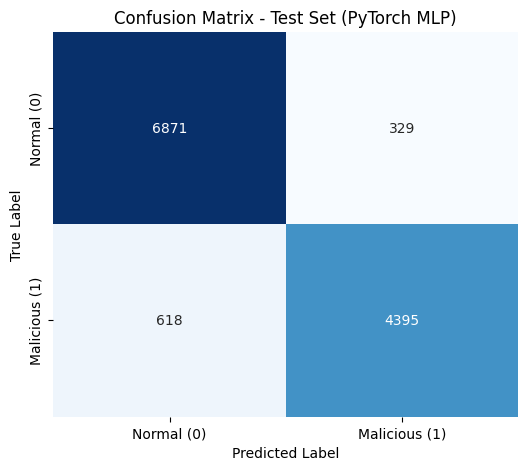

In [17]:
# NEW CELL: Evaluate the PyTorch MLP Model (REPLACES old Cell 6)

print("\n--- Evaluating the PyTorch MLP Model ---")

# Load the best model's weights
# Re-initialize the model with the same architecture
model = SimpleMLP(input_size, hidden_sizes, output_size, dropout_rate=DROPOUT_RATE).to(device)
model.load_state_dict(torch.load('best_pytorch_mlp_model.pth'))
model.eval() # Set to evaluation mode (essential for consistent predictions and disabling dropout)

# Collect predictions and true labels for evaluation
all_test_preds = []
all_test_probas = []
all_test_labels = []

with torch.no_grad(): # Disable gradient calculations for inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs) # Get probabilities (output of sigmoid)

        # Move to CPU and convert to numpy for sklearn metrics
        all_test_probas.extend(outputs.cpu().numpy())
        preds = (outputs > 0.5).float() # Threshold probabilities to get binary predictions
        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Convert lists to numpy arrays for sklearn metrics
all_test_preds = np.array(all_test_preds).flatten()
all_test_probas = np.array(all_test_probas).flatten()
all_test_labels = np.array(all_test_labels).flatten()

# Print evaluation metrics
print(f"\nEvaluation on Test Set (from Best Epoch {best_epoch}):")
print(f"Test Accuracy: {accuracy_score(all_test_labels, all_test_preds):.4f}")
print(f"Test F1-Score: {f1_score(all_test_labels, all_test_preds):.4f}")
print(f"Test ROC AUC: {roc_auc_score(all_test_labels, all_test_probas):.4f}")
print("\nTest Classification Report:")
print(classification_report(all_test_labels, all_test_preds))
print("\nTest Confusion Matrix:")
print(confusion_matrix(all_test_labels, all_test_preds))

# Plot Confusion Matrix for Test Set
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(all_test_labels, all_test_preds), annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal (0)', 'Malicious (1)'], yticklabels=['Normal (0)', 'Malicious (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set (PyTorch MLP)')
plt.show()

In [18]:
# Run this once in your training/setup environment if you haven't already:
from transformers import AutoTokenizer, AutoModel

# Define a directory to save the transformer components
TRANSFORMER_LOCAL_PATH = './saved_distilroberta_inference'

# Load and save the tokenizer
tokenizer = AutoTokenizer.from_pretrained('distilroberta-base')
tokenizer.save_pretrained(TRANSFORMER_LOCAL_PATH)
print(f"DistilRoBERTa Tokenizer saved to {TRANSFORMER_LOCAL_PATH}")

# Load and save the model
model = AutoModel.from_pretrained('distilroberta-base')
model.save_pretrained(TRANSFORMER_LOCAL_PATH)
print(f"DistilRoBERTa Model saved to {TRANSFORMER_LOCAL_PATH}")

DistilRoBERTa Tokenizer saved to ./saved_distilroberta_inference
DistilRoBERTa Model saved to ./saved_distilroberta_inference
